In [1]:
#멀티라벨 분류
#음식라벨 4가지를 데이터셋으로 만들었음

from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

#caltech_dir: 에서 이미지와 라벨명을 가져옴
caltech_dir = "D:/final"

#D:/final" 폴더에 있는 하위폴더이름을 불러오기(->categories)
categories  = os.listdir(caltech_dir)
nb_classes = len(categories )
image_w = 128
image_h = 128
pixels = image_h * image_w * 3

X = []
y = []

In [2]:
categories

['숙주나물', '순두부찌개', '시금치나물', '애호박볶음']

In [29]:
for idx, cat in enumerate(categories):
    
#one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 700 == 0:
            print(cat, " : ", f)

X = np.array(X)
y = np.array(y)

#1 0 0 0 이면 airplanes
#0 1 0 0 이면 buddha 이런식

X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("./numpy_data/np1.npy", xy)  #

print("ok", len(y))

숙주나물  파일 길이 :  967
숙주나물  :  D:/final/숙주나물\Img_043_0000.JPG
숙주나물  :  D:/final/숙주나물\Img_043_0729.jpg
순두부찌개  파일 길이 :  942
순두부찌개  :  D:/final/순두부찌개\Img_123_0000.jpg
순두부찌개  :  D:/final/순두부찌개\Img_123_0747.jpg
시금치나물  파일 길이 :  936
시금치나물  :  D:/final/시금치나물\Img_044_0000.JPG
시금치나물  :  D:/final/시금치나물\Img_044_0752.jpg
애호박볶음  파일 길이 :  947
애호박볶음  :  D:/final/애호박볶음\Img_045_0000.jpg
애호박볶음  :  D:/final/애호박볶음\Img_045_0743.jpg
ok 3792


In [ ]:
위에는 4가지(숙주나물~~애호박볶음)데이터셋 만드는거 
아래는 food128.npy데이터셋 불러와서 내가 만든 모델에 넣고 돌리는거

In [20]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

nb_classes=20
X_train, X_test, y_train, y_test = np.load('./food128.npy',allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])

(14023, 128, 128, 3)
14023


In [21]:
#categories = ["airplanes", "buddha", "butterfly", "crab"] 우리 모델을 라벨이 4개인데 폴더별로 이미 이름이 있고,라벨로 쓸예정임
#nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [22]:
with K.tf_ops.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_dir = './model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/food128.model'
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)

In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 65536)            

In [8]:
#print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

In [24]:
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Train on 14023 samples, validate on 4675 samples
Epoch 1/50
14023/14023 [==============================] - 33s 2ms/step - loss: 2.5631 - accuracy: 0.2138 - val_loss: 1.9479 - val_accuracy: 0.3499

Epoch 00001: val_loss improved from inf to 1.94790, saving model to ./model/food128.model
Epoch 2/50
14023/14023 [==============================] - 33s 2ms/step - loss: 1.9112 - accuracy: 0.3699 - val_loss: 1.6974 - val_accuracy: 0.4466

Epoch 00002: val_loss improved from 1.94790 to 1.69737, saving model to ./model/food128.model
Epoch 3/50
14023/14023 [==============================] - 33s 2ms/step - loss: 1.7082 - accuracy: 0.4347 - val_loss: 1.6085 - val_accuracy: 0.4806

Epoch 00003: val_loss improved from 1.69737 to 1.60848, saving model to ./model/food128.model
Epoch 4/50
14023/14023 [==============================] - 33s 2ms/step - loss: 1.5539 - accuracy: 0.4833 - val_loss: 1.5023 - val_accuracy: 0.5018

Epoch 00004: val_loss improved from 1.60848 to 1.50230, saving model to ./model/f

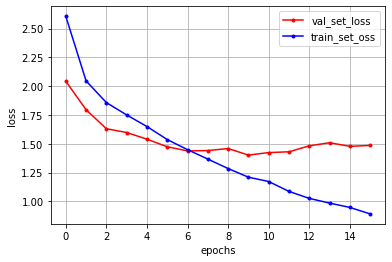

In [16]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [19]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

caltech_dir = "D:/final_test"
image_w = 128
image_h = 128

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)

X = np.array(X)
model = load_model('./food128.model')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

#이 비교는 그냥 파일들이 있으면 해당 파일과 비교. 카테고리와 함께 비교해서 진행하는 것은 _4 파일.
for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    print(i)
    print(pre_ans)
    pre_ans_str = categories[pre_ans]
    print("해당 "+"이미지는 "+pre_ans_str+"로 추정됩니다.")


[0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
3
해당 이미지는 애호박볶음로 추정됩니다.
[0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
5


IndexError: list index out of range

In [25]:
len(files)

2